# Customer Survival Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
df.PhoneService.unique()

array(['No', 'Yes'], dtype=object)

Here, Churn is an event which indicates whether customer exited or not. Tenure shows how long customer remained in our service. Both of these variables are very important for customer survival analysis.

In [4]:
df.Churn = labelencoder.fit_transform(df.Churn)
df.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [5]:
df['TotalCharges'] = df['TotalCharges'].replace(" ",np.nan)
df['TotalCharges'].fillna(0, inplace = True)
df['TotalCharges'] = df['TotalCharges'].astype(float)

C:\Users\sayan\AppData\Local\Temp\ipykernel_5812\3370260150.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace = True)


In [6]:
eventvar = df['Churn']
timevar = df['tenure']

For the analysis, I will need to create dummy variables for all categorical variables.

In [16]:
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod' , 'PhoneService']

survivaldata = pd.get_dummies(df, columns = categorical, drop_first= True,dtype=int)
survivaldata.head()

,customerID,tenure,InternetService,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes
0,7590-VHVEG,1,DSL,29.85,29.85,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,34,DSL,56.95,1889.50,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,3668-QPYBK,2,DSL,53.85,108.15,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,45,DSL,42.30,1840.75,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2,Fiber optic,70.70,151.65,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


We need to drop variables such as customerID, tenure, Churn as they are not needed in survival data. Also, we need to add constant for survival analysis.

In [17]:
survivaldata.drop(['customerID', 'tenure', 'Churn'], axis = 1, inplace= True)
survivaldata = st.add_constant(survivaldata, prepend=False)
survivaldata.head()

,InternetService,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,const
0,DSL,29.85,29.85,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1.0
1,DSL,56.95,1889.50,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,1.0
2,DSL,53.85,108.15,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1.0
3,DSL,42.30,1840.75,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1.0
4,Fiber optic,70.70,151.65,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1.0


## Survival Analysis

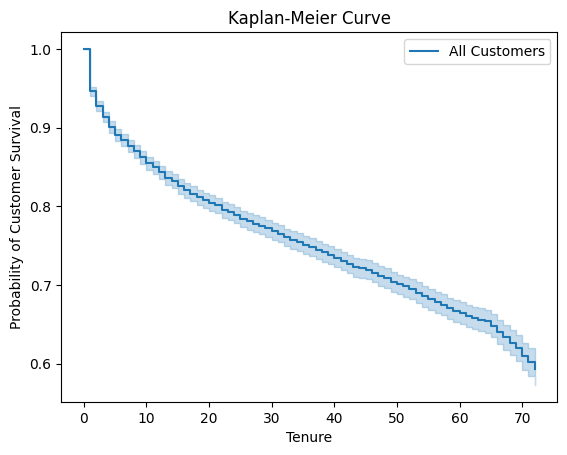

In [18]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Customers")
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

As we can see, there is a sudden drop in the starting which says that after one tenure only customers starts churning rapidly and after that churning rate decreases. To deal with that we can consider giving more discounts on long-term plans and make more customers to subscribe for long term plans.  

### Gender

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.09

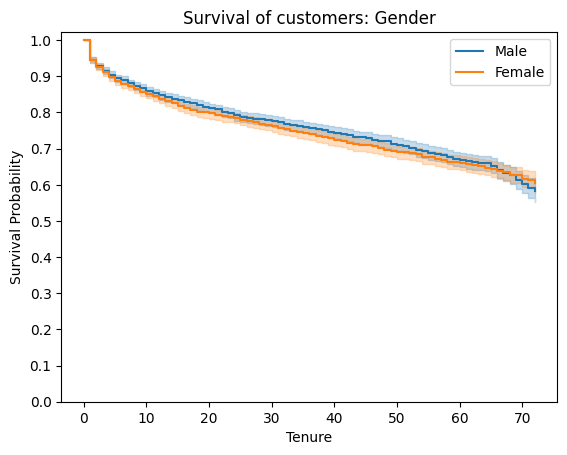

In [19]:
male = (survivaldata['gender_Male'] == 1)
female = (survivaldata['gender_Male'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[male],event_observed = eventvar[male],label = "Male")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[female],event_observed = eventvar[female],label = "Female")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Gender')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[male], timevar[female], event_observed_A=eventvar[male], event_observed_B=eventvar[female])
groups.print_summary()

### Senior Citizen

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         109.49 <0.005     82.71

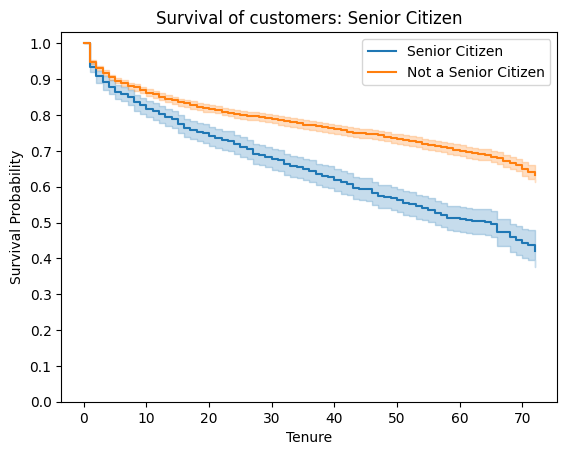

In [20]:
SeniorCitizen = (survivaldata['SeniorCitizen_1'] == 1)
no_SeniorCitizen = (survivaldata['SeniorCitizen_1'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[SeniorCitizen],event_observed = eventvar[SeniorCitizen],label = "Senior Citizen")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_SeniorCitizen],event_observed = eventvar[no_SeniorCitizen],label = "Not a Senior Citizen")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Senior Citizen')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[SeniorCitizen], timevar[no_SeniorCitizen], event_observed_A=eventvar[SeniorCitizen], event_observed_B=eventvar[no_SeniorCitizen])
groups.print_summary()

### Partner

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         423.54 <0.005    310.21

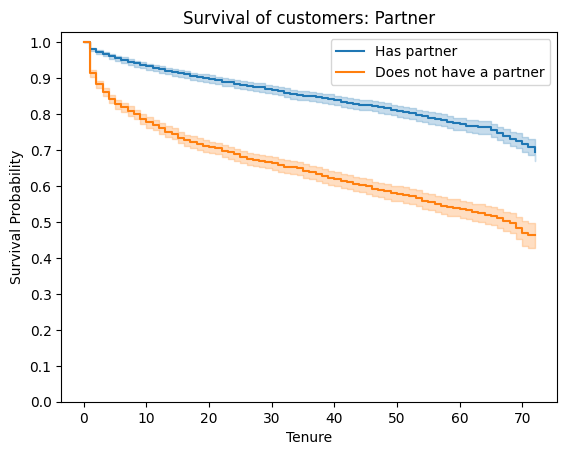

In [21]:
partner = (survivaldata['Partner_Yes'] == 1)
no_partner = (survivaldata['Partner_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[partner],event_observed = eventvar[partner],label = "Has partner")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_partner],event_observed = eventvar[no_partner],label = "Does not have a partner")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Partner')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[partner], timevar[no_partner], event_observed_A=eventvar[partner], event_observed_B=eventvar[no_partner])
groups.print_summary()

### Dependents

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         232.70 <0.005    172.12

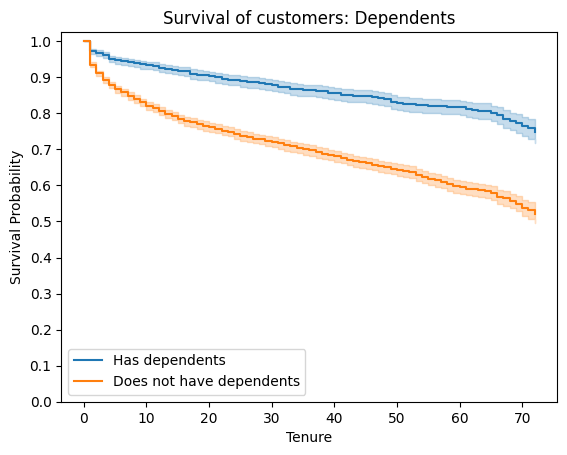

In [22]:
Dependents = (survivaldata['Dependents_Yes'] == 1)
no_Dependents = (survivaldata['Dependents_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Dependents],event_observed = eventvar[Dependents],label = "Has dependents")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_Dependents],event_observed = eventvar[no_Dependents],label = "Does not have dependents")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Dependents')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[Dependents], timevar[no_Dependents], event_observed_A=eventvar[Dependents], event_observed_B=eventvar[no_Dependents])
groups.print_summary()

### PhoneService

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.97

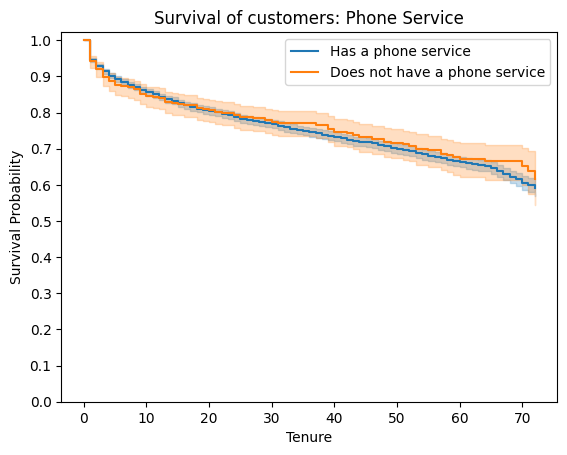

In [23]:
PhoneService = (survivaldata['PhoneService_Yes'] == 1)
no_PhoneService = (survivaldata['PhoneService_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[PhoneService],event_observed = eventvar[PhoneService],label = "Has a phone service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_PhoneService],event_observed = eventvar[no_PhoneService],label = "Does not have a phone service")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Phone Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PhoneService], timevar[no_PhoneService], event_observed_A=eventvar[PhoneService], event_observed_B=eventvar[no_PhoneService])
groups.print_summary()

### MultipleLines

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          30.97 <0.005     22.34

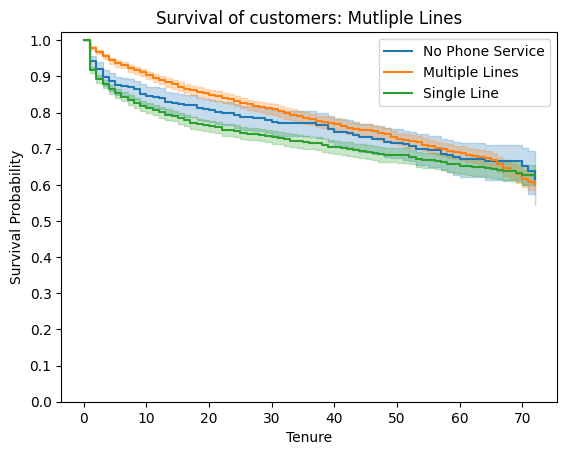

In [24]:
no_phone = (survivaldata['MultipleLines_No phone service'] == 1)
multiLines = (survivaldata['MultipleLines_Yes'] == 1)
no_multiLines = ((survivaldata['MultipleLines_Yes'] == 0) & (survivaldata['MultipleLines_No phone service'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_phone],event_observed = eventvar[no_phone],label = "No Phone Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[multiLines],event_observed = eventvar[multiLines],label = "Multiple Lines")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_multiLines],event_observed = eventvar[no_multiLines],label = "Single Line")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Mutliple Lines')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['MultipleLines'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Internet Service

In [25]:
Fiber_optic = (survivaldata['InternetService_Fiber optic'] == 1)
No_Service = (survivaldata['InternetService_No'] == 1)
DSL = ((survivaldata['InternetService_Fiber optic'] == 0) & (survivaldata['InternetService_No'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Fiber_optic],event_observed = eventvar[Fiber_optic],label = "Fiber optic")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[No_Service],event_observed = eventvar[No_Service],label = "No Service")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[DSL],event_observed = eventvar[DSL],label = "DSL")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Internet Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['InternetService'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

KeyError: 'InternetService_Fiber optic'

### Online Security

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        1013.86 <0.005    731.35

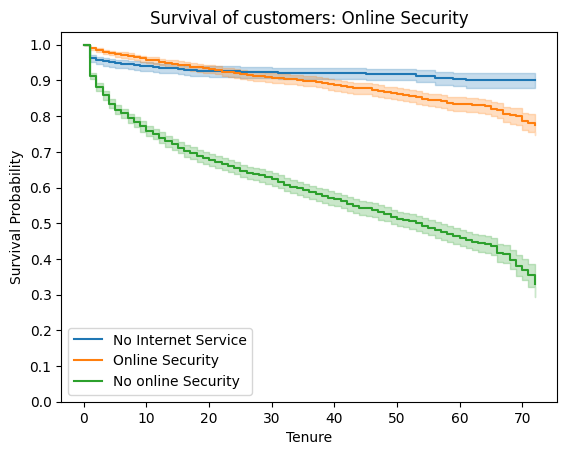

In [26]:
no_internetService = (survivaldata['OnlineSecurity_No internet service'] == 1)
onlineSecurity = (survivaldata['OnlineSecurity_Yes'] == 1)
no_onlineSecurity = ((survivaldata['OnlineSecurity_No internet service'] == 0) & (survivaldata['OnlineSecurity_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[onlineSecurity],event_observed = eventvar[onlineSecurity],label = "Online Security")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineSecurity],event_observed = eventvar[no_onlineSecurity],label = "No online Security")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Security')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['OnlineSecurity'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Online Backup

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         821.34 <0.005    592.47

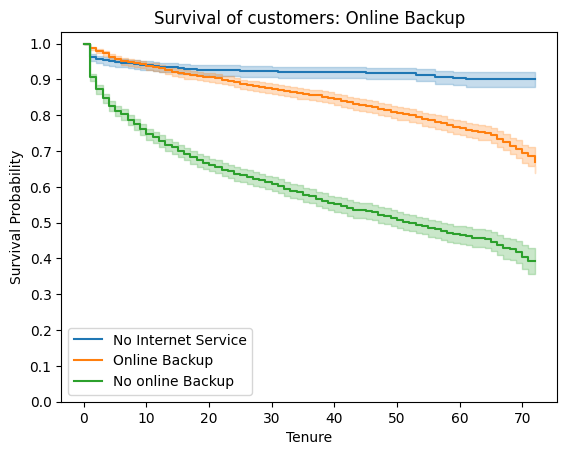

In [27]:
no_internetService = (survivaldata['OnlineBackup_No internet service'] == 1)
onlineBackup = (survivaldata['OnlineBackup_Yes'] == 1)
no_onlineBackup = ((survivaldata['OnlineBackup_No internet service'] == 0) & (survivaldata['OnlineBackup_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[onlineBackup],event_observed = eventvar[onlineBackup],label = "Online Backup")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineBackup],event_observed = eventvar[no_onlineBackup],label = "No online Backup")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Backup')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['OnlineBackup'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Device Protection

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         763.51 <0.005    550.75

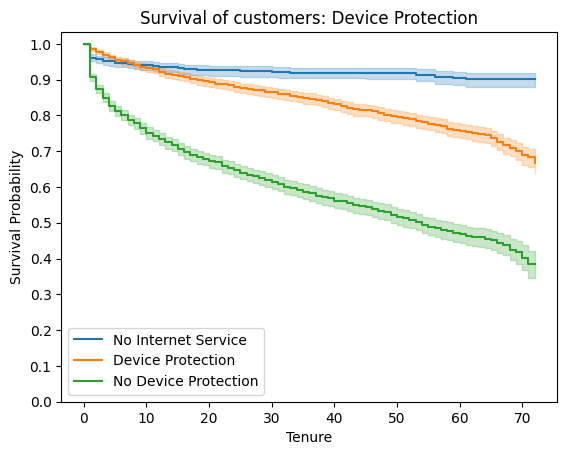

In [28]:
no_internetService = (survivaldata['DeviceProtection_No internet service'] == 1)
DeviceProtection = (survivaldata['DeviceProtection_Yes'] == 1)
no_DeviceProtection = ((survivaldata['DeviceProtection_No internet service'] == 0) & (survivaldata['DeviceProtection_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[DeviceProtection],event_observed = eventvar[DeviceProtection],label = "Device Protection")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_DeviceProtection],event_observed = eventvar[no_DeviceProtection],label = "No Device Protection")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Device Protection')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['DeviceProtection'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Tech Support

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         989.56 <0.005    713.82

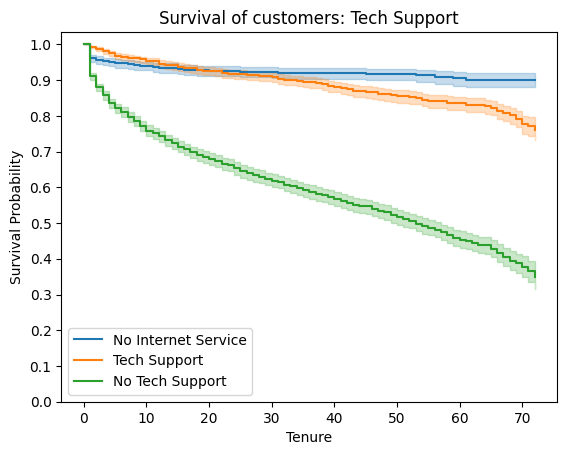

In [29]:
no_internetService = (survivaldata['TechSupport_No internet service'] == 1)
TechSupport = (survivaldata['TechSupport_Yes'] == 1)
no_TechSupport = ((survivaldata['TechSupport_No internet service'] == 0) & (survivaldata['TechSupport_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[TechSupport],event_observed = eventvar[TechSupport],label = "Tech Support")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_TechSupport],event_observed = eventvar[no_TechSupport],label = "No Tech Support")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Tech Support')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['TechSupport'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Streaming TV

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         368.31 <0.005    265.68

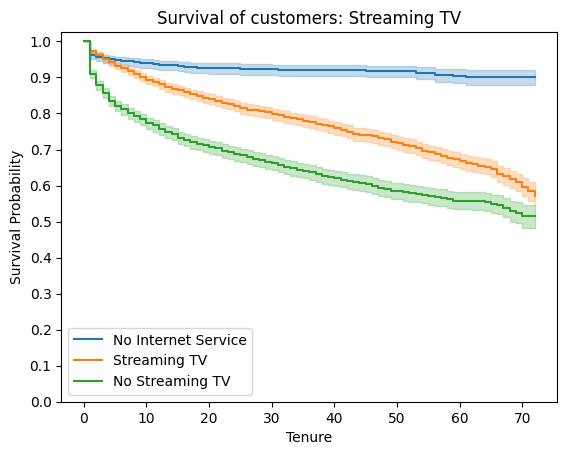

In [30]:
no_internetService = (survivaldata['StreamingTV_No internet service'] == 1)
StreamingTV = (survivaldata['StreamingTV_Yes'] == 1)
no_StreamingTV = ((survivaldata['StreamingTV_No internet service'] == 0) & (survivaldata['StreamingTV_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingTV],event_observed = eventvar[StreamingTV],label = "Streaming TV")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingTV],event_observed = eventvar[no_StreamingTV],label = "No Streaming TV")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming TV')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['StreamingTV'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Streaming Movies

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         378.43 <0.005    272.98

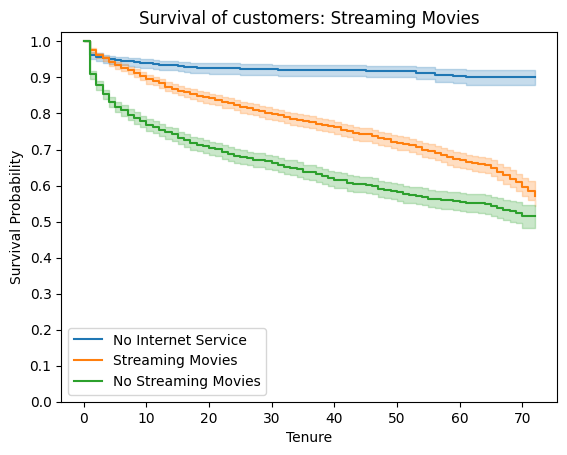

In [31]:
no_internetService = (survivaldata['StreamingMovies_No internet service'] == 1)
StreamingMovies = (survivaldata['StreamingMovies_Yes'] == 1)
no_StreamingMovies = ((survivaldata['StreamingMovies_No internet service'] == 0) & (survivaldata['StreamingMovies_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingMovies],event_observed = eventvar[StreamingMovies],label = "Streaming Movies")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingMovies],event_observed = eventvar[no_StreamingMovies],label = "No Streaming Movies")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming Movies')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['StreamingMovies'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Contract

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        2352.87 <0.005       inf

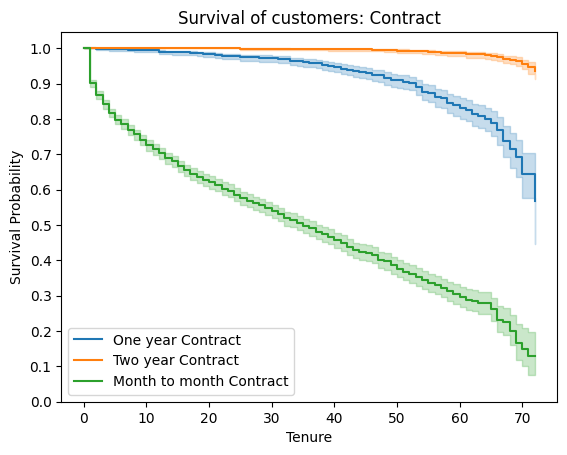

In [32]:
Contract_One_year = (survivaldata['Contract_One year'] == 1)
Contract_Two_year = (survivaldata['Contract_Two year'] == 1)
Contract_month_to_month = ((survivaldata['Contract_One year'] == 0) & (survivaldata['Contract_Two year'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Contract_One_year],event_observed = eventvar[Contract_One_year],label = "One year Contract")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[Contract_Two_year],event_observed = eventvar[Contract_Two_year],label = "Two year Contract")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[Contract_month_to_month],event_observed = eventvar[Contract_month_to_month],label = "Month to month Contract")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Contract')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['Contract'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Payment Method

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         865.24 <0.005    619.58

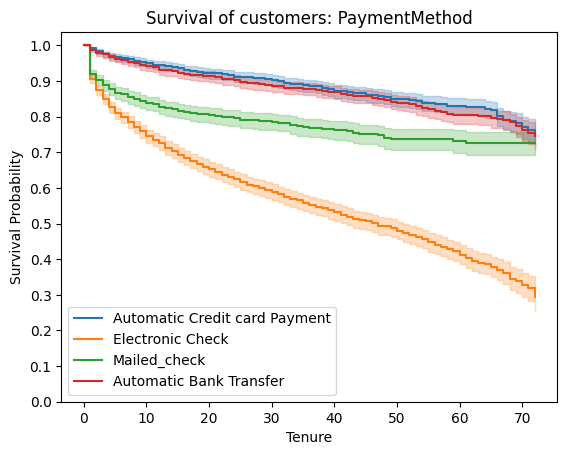

In [33]:
automatic_Credit_Card = (survivaldata['PaymentMethod_Credit card (automatic)'] == 1)
electronic_check = (survivaldata['PaymentMethod_Electronic check'] == 1)
mailed_check = (survivaldata['PaymentMethod_Mailed check'] == 1)
automatic_Bank_Transfer = ((survivaldata['PaymentMethod_Credit card (automatic)'] == 0) & (survivaldata['PaymentMethod_Electronic check'] == 0) & (survivaldata['PaymentMethod_Mailed check'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[automatic_Credit_Card],event_observed = eventvar[automatic_Credit_Card],label = "Automatic Credit card Payment")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[electronic_check],event_observed = eventvar[electronic_check],label = "Electronic Check")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[mailed_check],event_observed = eventvar[mailed_check],label = "Mailed_check")
plot3 = kmf.plot(ax = plot2)

kmf.fit(timevar[automatic_Bank_Transfer],event_observed = eventvar[automatic_Bank_Transfer],label = "Automatic Bank Transfer")
plot4 = kmf.plot(ax = plot3)
                 
plt.title('Survival of customers: PaymentMethod')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['PaymentMethod'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Paperless Billing

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         189.51 <0.005    140.82

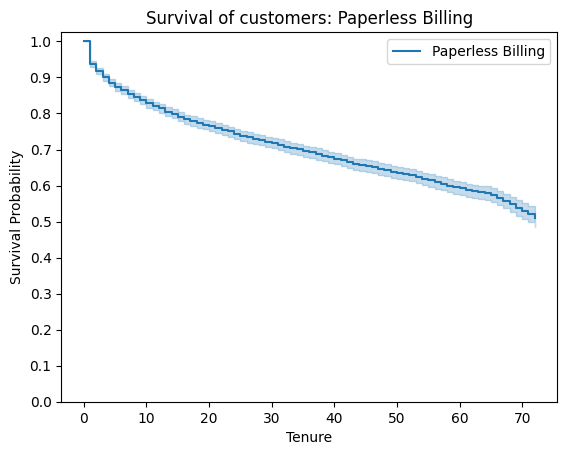

In [34]:
PaperlessBilling = (survivaldata['PaperlessBilling_Yes'] == 1)
no_PaperlessBilling = (survivaldata['PaperlessBilling_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[PaperlessBilling],event_observed = eventvar[PaperlessBilling],label = "Paperless Billing")
plot1 = kmf.plot(ax = ax)

plt.title('Survival of customers: Paperless Billing')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PaperlessBilling], timevar[no_PaperlessBilling], event_observed_A=eventvar[PaperlessBilling], event_observed_B=eventvar[no_PaperlessBilling])
groups.print_summary()

Plotting 16 categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


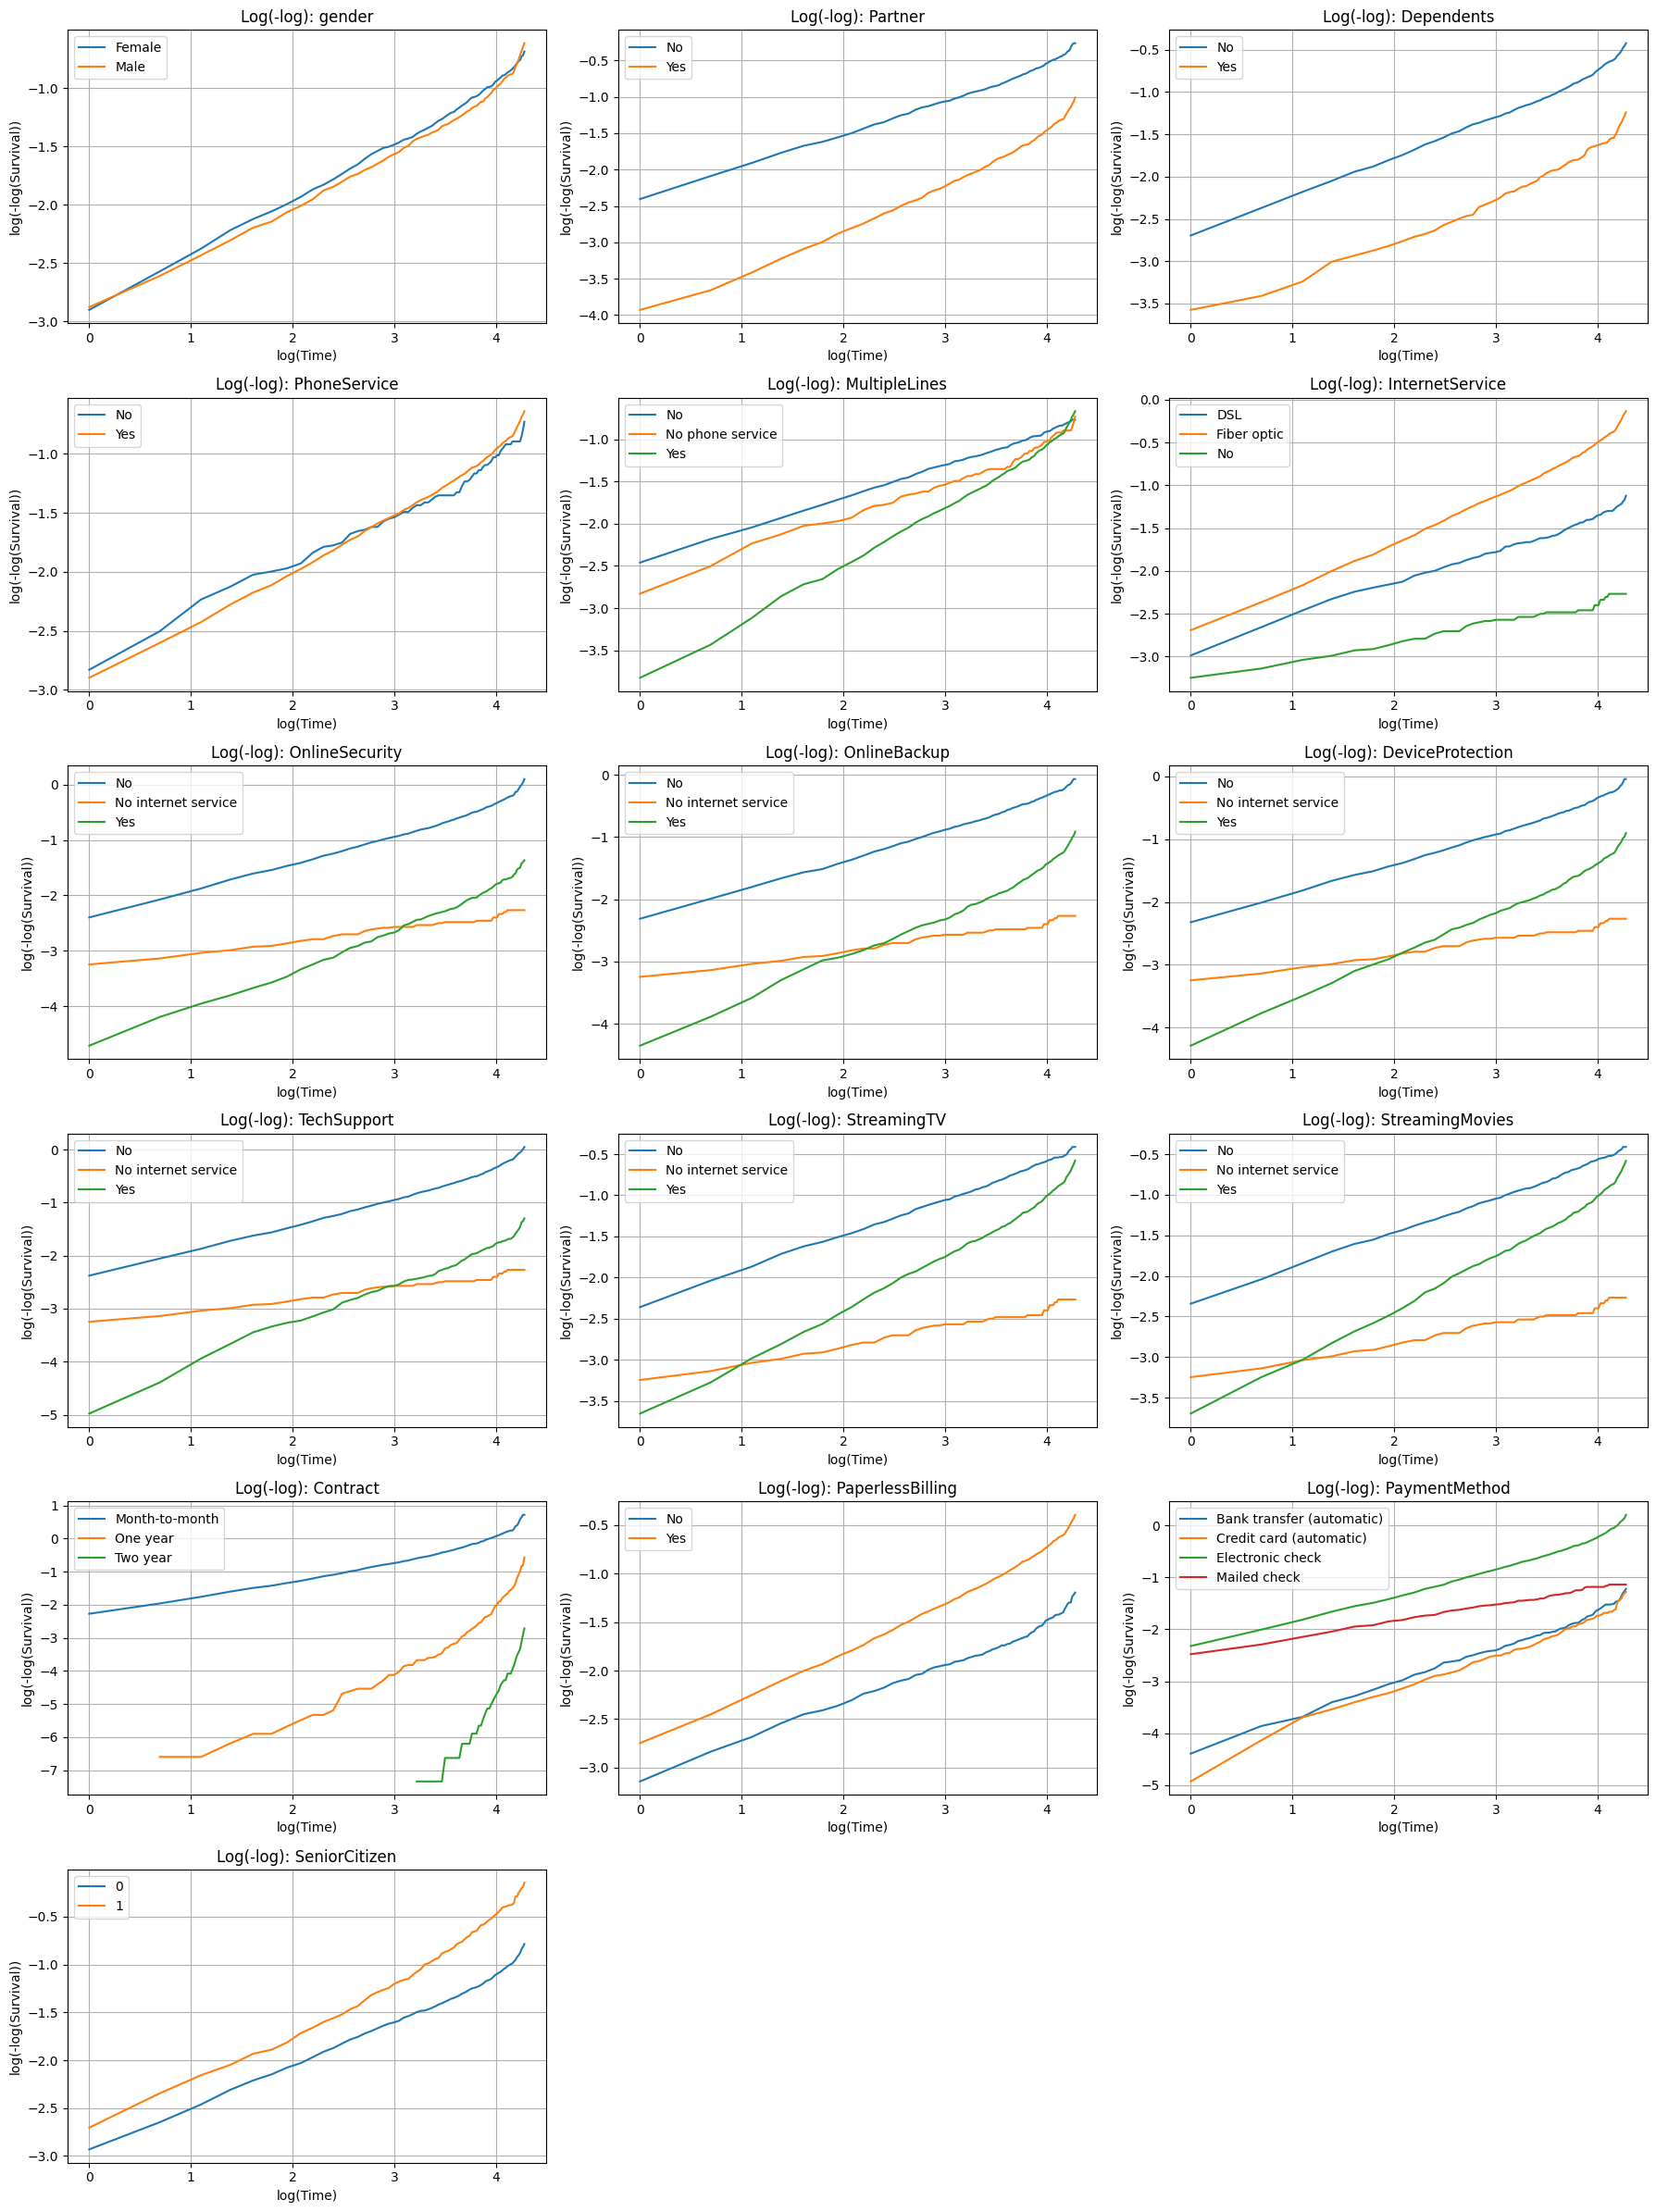

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preprocess
df['churn_event'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

# Detect usable categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['customerID', 'Churn']]

# Add 'SeniorCitizen' as categorical
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
categorical_cols.append('SeniorCitizen')

# OPTIONAL: Limit columns with <= 6 unique categories for better readability
categorical_cols = [col for col in categorical_cols if df[col].nunique() <= 6]

# Check how many to plot
n = len(categorical_cols)
print(f"Plotting {n} categorical columns: {categorical_cols}")

# Set subplot grid
n_cols = 3
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Loop through each categorical column
for i, col in enumerate(categorical_cols):
    ax = axes[i]
    df[col] = df[col].astype('category')  # ensure categorical

    for group in df[col].cat.categories:
        group_df = df[df[col] == group]
        if group_df.empty:
            continue
        
        kmf.fit(group_df['tenure'], group_df['churn_event'], label=str(group))
        sf = kmf.survival_function_

        # Avoid log(0)
        if sf[kmf._label].le(0).any():
            sf = sf[sf[kmf._label] > 0]
        if sf.empty:
            continue

        log_time = np.log(sf.index)
        loglog_survival = np.log(-np.log(sf[kmf._label]))

        ax.plot(log_time, loglog_survival, label=str(group))

    ax.set_title(f"Log(-log): {col}")
    ax.set_xlabel("log(Time)")
    ax.set_ylabel("log(-log(Survival))")
    ax.legend()
    ax.grid(True)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Survival Regression

In [36]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df['TotalCharges'] = df['TotalCharges'].replace(" ",np.nan)
    df['TotalCharges'].fillna(0, inplace = True)
    df['TotalCharges'] = df['TotalCharges'].astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})

    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True,dtype=int)
    
    return df

In [37]:
regression_df = datapreparation("WA_Fn-UseC_-Telco-Customer-Churn.csv")
regression_df.head()

C:\Users\sayan\AppData\Local\Temp\ipykernel_5812\3802380306.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace = True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif = pd.DataFrame()
vif["feature"] = regression_df.columns
vif["VIF"] = [variance_inflation_factor(regression_df.values, i) for i in range(regression_df.shape[1])]
print(vif)

                                  feature         VIF
0                                  gender    1.980781
1                           SeniorCitizen    1.378643
2                                 Partner    2.827280
3                              Dependents    1.977378
4                                  tenure   20.301372
5                            PhoneService   47.570851
6                           MultipleLines    2.850990
7                          OnlineSecurity    2.698703
8                            OnlineBackup    2.912920
9                        DeviceProtection    3.004559
10                            TechSupport    2.782212
11                            StreamingTV    4.930957
12                        StreamingMovies    5.070101
13                       PaperlessBilling    2.964178
14                         MonthlyCharges  217.716916
15                           TotalCharges   21.477731
16                                  Churn    1.897950
17            InternetServic

In [39]:
regression_df.drop(columns=['PhoneService','MonthlyCharges'],inplace=True)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif = pd.DataFrame()
vif["feature"] = regression_df.columns
vif["VIF"] = [variance_inflation_factor(regression_df.values, i) for i in range(regression_df.shape[1])]
print(vif)

                                  feature        VIF
0                                  gender   1.881722
1                           SeniorCitizen   1.369771
2                                 Partner   2.815493
3                              Dependents   1.958943
4                                  tenure  16.857031
5                           MultipleLines   2.399966
6                          OnlineSecurity   1.946160
7                            OnlineBackup   2.175933
8                        DeviceProtection   2.297996
9                             TechSupport   2.062592
10                            StreamingTV   2.764831
11                        StreamingMovies   2.790368
12                       PaperlessBilling   2.749110
13                           TotalCharges  18.586245
14                                  Churn   1.807576
15            InternetService_Fiber optic   3.680593
16                     InternetService_No   2.728886
17                      Contract_One year   2.

#### Survival Regression Ananlysis using Cox Proportional Hazard model

In [41]:
cph = CoxPHFitter()
cph.fit(regression_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12711.55
         time fit was run = 2025-07-09 12:03:41 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                 0.06      1.06      0.05           -0.03            0.15                0.97                1.16
SeniorCitizen                          0.00      1.00      0.06           -0.11            0.11                0.90                1.12
Partner                               -0.19      0.83      0.05           -0.30           -0.08                0.74                0.92
Dependents                            -0.06      0.94      0.07           -0.20            0.07                0.82                1.08
MultipleLines                          0.24      1.27      0.05            0.14            0.34                1.15                1.41
OnlineSecurity                        -0.13      0.88      0.07           -0.26            0.01                0.77                1.01
OnlineBackup                          -0.03      0.97      0.05           -0.13            0.08                0.88                1.08
DeviceProtection                       0.12      1.13      0.05            0.01            0.22                1.01                1.25
TechSupport                            0.00      1.00      0.07           -0.13            0.13                0.88                1.14
StreamingTV                            0.36      1.43      0.05            0.26            0.46                1.29                1.59
StreamingMovies                        0.36      1.43      0.05            0.26            0.46                1.29                1.59
PaperlessBilling                       0.12      1.13      0.06            0.01            0.23                1.01                1.26
TotalCharges                          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
InternetService_Fiber optic            1.71      5.54      0.07            1.57            1.85                4.80                6.39
InternetService_No                    -2.02      0.13      0.14           -2.30           -1.75                0.10                0.17
Contract_One year                     -1.22      0.29      0.10           -1.42           -1.03                0.24                0.36
Contract_Two year                     -3.62      0.03      0.20           -4.01           -3.23                0.02                0.04
PaymentMethod_Credit card (automatic) -0.01      0.99      0.09           -0.19            0.16                0.83                1.18
PaymentMethod_Electronic check         0.39      1.48      0.07            0.25            0.53                1.28                1.70
PaymentMethod_Mailed check             0.56      1.76      0.09            0.39            0.74                1.48                2.09

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00   1.23   0.22      2.20
SeniorCitizen                            0.00   0.06   0.95      0.07
Partner                                  0.00  -3.46 <0.005     10.83
Dependents                               0.00  -0.91   0.36      1.47
MultipleLines                            0.00   4.63 <0.005     18.05
OnlineSecurity                           0.00  -1.87   0.06      4.01
OnlineBackup                             0.00  -0.47   0.64      0.65
DeviceProtec

In [42]:
cph.check_assumptions(regression_df, p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km            114.67 <0.005     86.47
                                      rank          102.53 <0.005     77.64
Contract_Two year                     km            136.82 <0.005    102.58
                                      rank          110.77 <0.005     83.64
Dependents                            km              0.01   0.91      0.14
                                      rank            0.02   0.90      0.15
DeviceProtection                      km              4.03   0.04      4.48
                                      rank            6.79   0.01      6.77
InternetService_Fiber optic           km            181.76 <0.005    135.20
                                      rank          252.92 <0.005    186.76
InternetService_No                    km             75.15 <0.005     57.67
                                      rank           83.62 <0.005     63.86
MultipleLines                         km             19.37 <0.005     16.50
                                      rank           33.37 <0.005     26.97
OnlineBackup                          km              7.52   0.01      7.36
                                      rank           10.81 <0.005      9.95
OnlineSecurity                        km              6.75   0.01      6.74
                                      rank           11.61 <0.005     10.58
PaperlessBilling                      km              0.02   0.90      0.15
                                      rank            0.10   0.75      0.42
Partner                               km              3.03   0.08      3.62
                                      rank            5.07   0.02      5.36
PaymentMethod_Credit card (automatic) km              2.88   0.09      3.48
                                      rank            2.19   0.14      2.84
PaymentMethod_Electronic check        km              0.41   0.52      0.94
                                      rank            0.00   0.97      0.05
PaymentMethod_Mailed check            km              0.32   0.57      0.81
                                      rank            0.13   0.72      0.48
SeniorCitizen                         km              3.79   0.05      4.28
                                      rank            2.26   0.13      2.91
StreamingMovies                       km             18.63 <0.005     15.94
                                      rank           27.13 <0.005     22.32
StreamingTV                           km             26.81 <0.005     22.09
                                      rank           34.96 <0.005     28.14
TechSupport                           km              9.02 <0.005      8.55
                                      rank           14.34 <0.005     12.68
TotalCharges                          km            256.55 <0.005    189.39
                                      rank           68.18 <0.005     52.57
gender                                km              0.47   0.49      1.02
                                      rank            1.31   0.25      1.98



1. Variable 'SeniorCitizen' failed the non-proportional test: p-value is 0.0515.

   Advice: with so few unique values (only 2), you can include `strata=['SeniorCitizen', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'Partner' failed the non-proportional test: p-value is 0.0244.

   Advice: with so few unique values (only 2), you can include `strata=['Partner', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'MultipleLines' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['MultipleLines', ...]` in
the call in `.fit`. See documentation in link [E] below.

4. Variable 'OnlineSecurity' failed the non-proportional test: p-value is 0.0007.

   Advice: with so few unique values (only 2), you can include `strata=['OnlineSecurity', ...]` in
the call in `.fit`. See documentation in link [E] below.

5. Variable 'OnlineBackup' failed the non-proportional t

[]

In [ ]:
#regression_df["TotalCharges_binned"] = pd.cut(regression_df["TotalCharges"], bins=5)
#regression_df = pd.get_dummies(regression_df, columns=["TotalCharges_binned"], drop_first=True,dtype=int)
#regression_df.drop(columns='TotalCharges',inplace=True)

In [43]:
cph = CoxPHFitter()
cph.fit(regression_df, duration_col='tenure', event_col='Churn',
        strata=[
          'SeniorCitizen', 'Partner', 'MultipleLines', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection', 'TechSupport',
          'StreamingTV', 'StreamingMovies',
          'InternetService_Fiber optic', 'InternetService_No',
          'Contract_One year', 'Contract_Two year'
        ])

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [44]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                   strata = ['SeniorCitizen', 'Partner', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year']
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -2175.19
         time fit was run = 2025-07-09 12:03:54 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                -0.01      0.99      0.07           -0.14            0.12                0.87                1.13
Dependents                             0.04      1.04      0.10           -0.16            0.24                0.85                1.27
PaperlessBilling                       0.17      1.19      0.08            0.02            0.32                1.02                1.38
TotalCharges                          -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
PaymentMethod_Credit card (automatic) -0.25      0.78      0.14           -0.53            0.03                0.59                1.03
PaymentMethod_Electronic check         0.11      1.12      0.11           -0.10            0.32                0.91                1.38
PaymentMethod_Mailed check             0.04      1.04      0.12           -0.21            0.28                0.81                1.32

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00  -0.10   0.92      0.12
Dependents                               0.00   0.41   0.68      0.55
PaperlessBilling                         0.00   2.24   0.03      5.30
TotalCharges                             0.00 -26.32 <0.005    504.79
PaymentMethod_Credit card (automatic)    0.00  -1.78   0.07      3.74
PaymentMethod_Electronic check           0.00   1.06   0.29      1.78
PaymentMethod_Mailed check               0.00   0.29   0.78      0.37
---
Concordance = 0.92
Partial AIC = 4364.39
log-likelihood ratio test = 3683.40 on 7 df
-log2(p) of ll-ratio test = inf

In [45]:
cph.check_assumptions(regression_df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Dependents                            km              0.04   0.85      0.24
                                      rank            0.09   0.77      0.39
PaperlessBilling                      km              0.77   0.38      1.40
                                      rank            0.07   0.79      0.33
PaymentMethod_Credit card (automatic) km              0.44   0.51      0.98
                                      rank            0.71   0.40      1.33
PaymentMethod_Electronic check        km              0.45   0.50      0.99
                                      rank            0.01   0.93      0.10
PaymentMethod_Mailed check            km              0.03   0.85      0.23
                                      rank            0.05   0.82      0.29
TotalCharges                          km             73.41 <0.005     56.39
                                      rank           20.07 <0.005     17.03
gender                                km              0.44   0.51      0.98
                                      rank            0.02   0.89      0.17



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20

[]

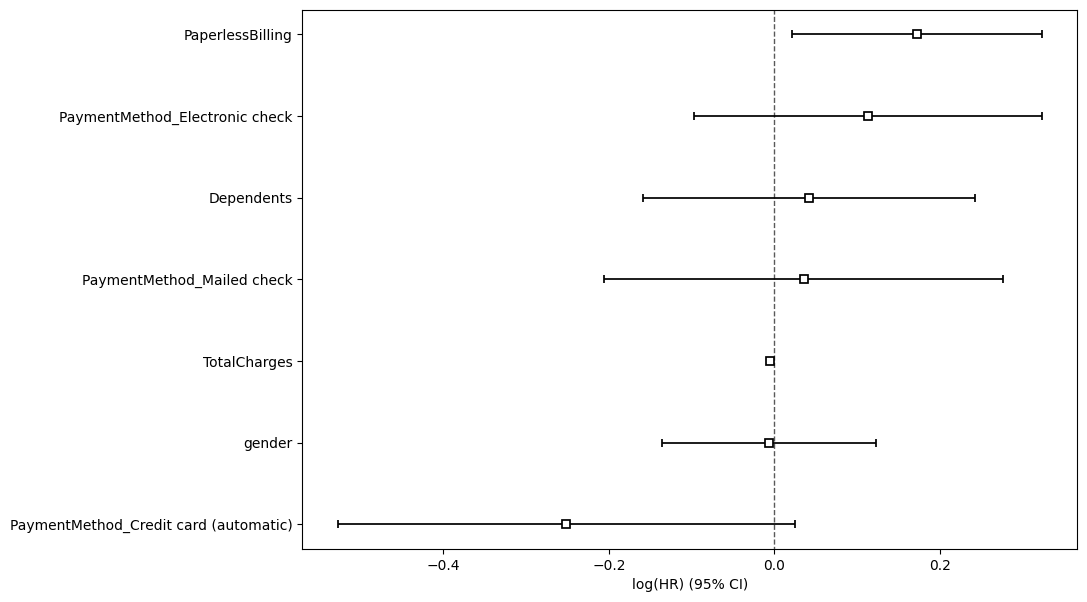

In [46]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax);

In [65]:
test_id = regression_df.sample(1)

In [48]:
cph.summary.loc['TotalCharges']

coef                   -5.064275e-03
exp(coef)               9.949485e-01
se(coef)                1.924044e-04
coef lower 95%         -5.441381e-03
coef upper 95%         -4.687169e-03
exp(coef) lower 95%     9.945734e-01
exp(coef) upper 95%     9.953238e-01
cmp to                  0.000000e+00
z                      -2.632099e+01
p                      1.103069e-152
-log2(p)                5.047915e+02
Name: TotalCharges, dtype: float64

<Axes: xlabel='TotalCharges_capped', ylabel='Density'>

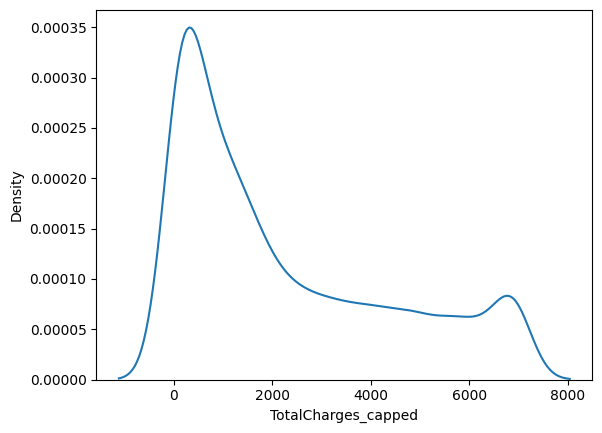

In [49]:
# Step 1: Compute the 95th percentile
percentile_95 = regression_df['TotalCharges'].quantile(0.95)

# Step 2: Cap the values above the 95th percentile
regression_df['TotalCharges_capped'] = np.where(
    regression_df['TotalCharges'] > percentile_95,
    percentile_95,
    regression_df['TotalCharges']
)
import seaborn as sns
sns.kdeplot(regression_df.TotalCharges_capped)

In [10]:
regression_df.drop(columns='TotalCharges',inplace=True)

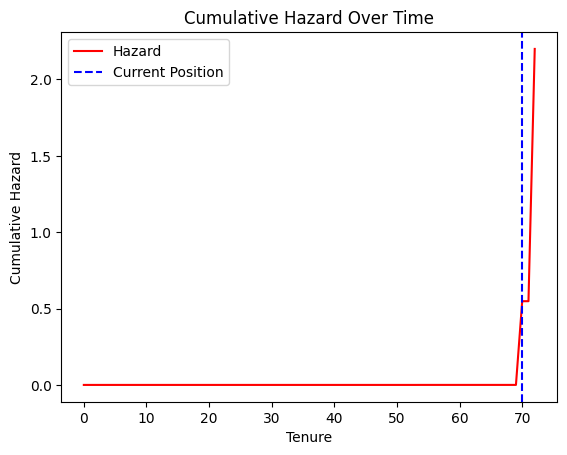

In [66]:
fig, ax = plt.subplots()
cph.predict_cumulative_hazard(test_id).plot(ax = ax, color = 'red')
plt.axvline(x=test_id.tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Hazard','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Cumulative Hazard', size = 10)
ax.set_title('Cumulative Hazard Over Time');

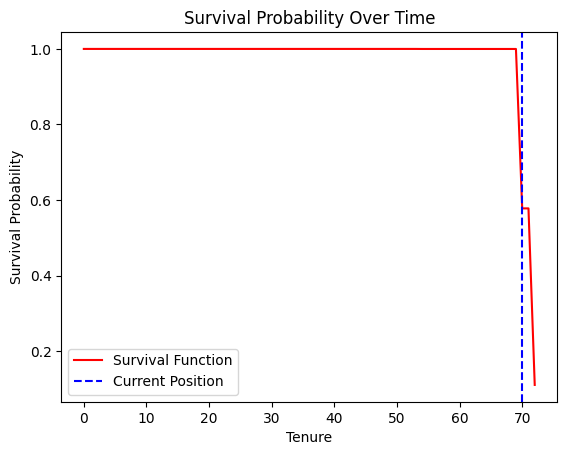

In [67]:
fig, ax = plt.subplots()
cph.predict_survival_function(test_id).plot(ax = ax, color = 'red')
plt.axvline(x=test_id.tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time');

Saving the model

<Axes: xlabel='tenure', ylabel='Count'>

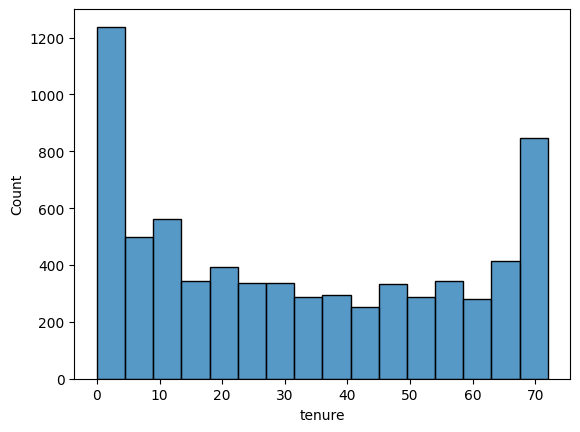

In [55]:
sns.histplot(data=regression_df , x='tenure')

## Customer Lifetime Value

To calculate customer lifetime value, I would multiply the Monthly charges the customer is paying to Telcom and the expected life time of the customer. 

I utilize the survival function of a customer to calculate its expected life time. I would like to be little bit conservative and consider the customer is churned when the survival probability of him is 10%. 

In [84]:
def LTV(info):
    life = cph.predict_survival_function(info).reset_index()
    life.columns = ['Tenure', 'Probability']
    max_life = life.Tenure[life.Probability > 0.1].max()
    
    LTV = max_life * df['MonthlyCharges'][test_id.index[0]]
    return LTV

In [85]:
print('LTV of a testid is:', LTV(test_id), 'dollars.')

LTV of a testid is: 7884.0 dollars.
